In [213]:
import sys
sys.path.insert(0,'/home/jovyan/work/src/')
from sqlalchemy import create_engine, MetaData, select
from sqlalchemy.orm import sessionmaker
from arise.barcode.metadata.orm.barcode import Barcode
from arise.barcode.metadata.orm.marker import Marker
from arise.barcode.metadata.orm.nsr_species import NsrSpecies
from arise.barcode.metadata.orm.nsr_synonym import NsrSynonym
from arise.barcode.metadata.orm.nsr_node import NsrNode
from arise.barcode.metadata.orm.specimen import Specimen
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
from ete3 import Tree, TreeStyle
import os
from ipywidgets import IntProgress
from IPython.display import display

os.environ['QT_QPA_PLATFORM']='offscreen'  # to avoid to kill the kernel using ete render
os.environ['XDG_RUNTIME_DIR']='/tmp/runtime-jovyan'

In [214]:
engine = create_engine('sqlite:////home/jovyan/work/data/sqlite/arise-barcode-metadata.db', echo=False)

# make session
Session = sessionmaker(engine)
session = Session()

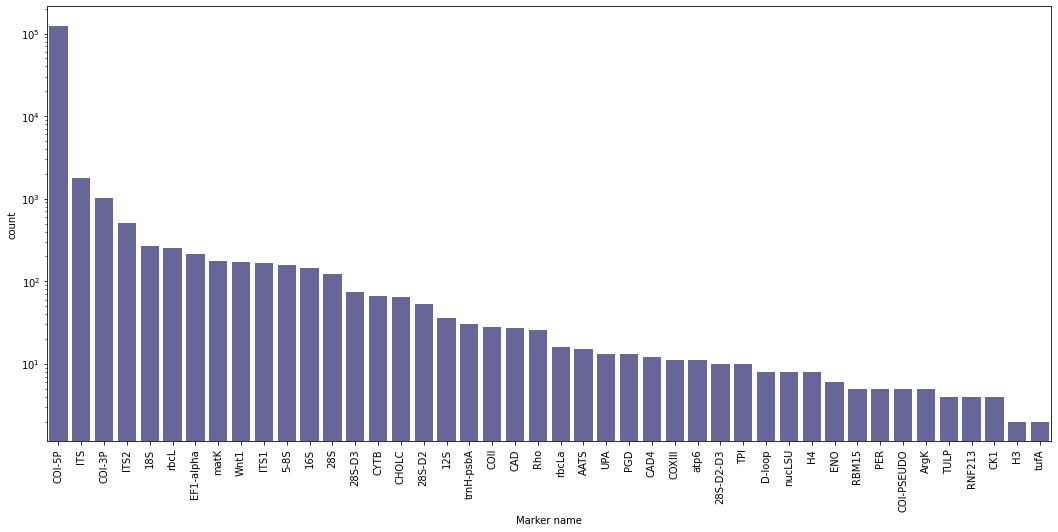

In [215]:
# with relationship()
# nsr_barcodes = session.query(Barcode).all()
# data = [el.marker.marker_name for el in nsr_barcodes]

# without?
markers = session.query(Barcode.marker_id, Marker.marker_name).join(Marker).all()
data = [el[1] for el in markers]
df = pd.DataFrame(data, columns=['Marker name']).sort_values(by=['Marker name'])
fig, ax = plt.subplots(figsize=(18,8))
sb.countplot(data=df, x='Marker name', ax=ax, color='b', saturation=0.2, order = df['Marker name'].value_counts().index)
ax.set_yscale('log')
ax.tick_params(axis="x", rotation=90)

<AxesSubplot:xlabel='count', ylabel='Institution'>

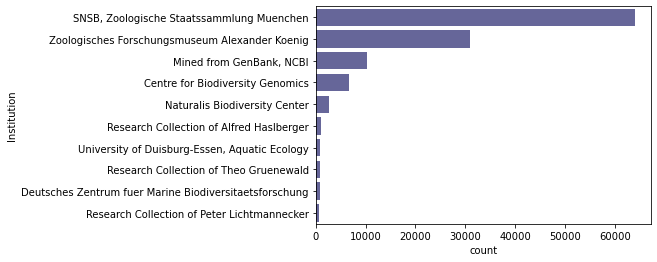

In [216]:
institutions = session.query(Specimen.institution_storing).all()
institutions = [e[0] for e in institutions if e[0]]
df = pd.DataFrame(institutions, columns=['Institution']).sort_values(by=['Institution'])
indices = df['Institution'].value_counts().index
sb.countplot(data=df, y='Institution', color='b', saturation=0.2, order = indices[0:10])

In [217]:
# here we go and traverse the tree from the root
nsr_root = NsrNode.get_root(session)
print(nsr_root.name)

All of life


In [218]:
# walks across the tree, stores number of tips and barcodes as total_sp and total_bc
# populates an ete3 tree up to max_rank level, e.g. families as tips
# tags the nodes with their taxonomic rank
def recurse(nsr_node, ete_node, max_rank, session, f):
    if nsr_node.rank == max_rank:
        tips = nsr_node.get_descendants(session).all()
        total_bc = 0
        for tip in tips:
            specimens = session.query(Specimen).filter(Specimen.species_id == tip.species_id)
            for spec in specimens:
                barcodes = spec.barcodes
                total_bc += len(barcodes)
        ete_node.add_feature('total_sp', len(tips))
        ete_node.add_feature('total_bc', total_bc)        
        f.value += len(tips)
    else:
        total_bc = 0
        total_sp = 0
        for child in nsr_node.get_children(session):
            ete_child = ete_node.add_child(name = child.name)
            ete_child.add_feature('rank',nsr_node.rank)
            recurse(child, ete_child, max_rank, session, f)
            total_bc += ete_child.total_bc
            total_sp += ete_child.total_sp
        ete_node.add_feature('total_sp', total_sp)
        ete_node.add_feature('total_bc', total_bc)           

# instantiate tree
tree = Tree()
ete_root = tree.add_child(name = nsr_root.name)
ete_root.add_feature('rank','life')

# configure progress bar
max_count = session.query(NsrSpecies.species_id).count()
f = IntProgress(min=0, max=max_count)
display(f)

# start recursing. this will take a while!
recurse(nsr_root, ete_root, 'family', session, f)     
f.value = max_count
print("Done. Now that you sat through this, store the result in the next cell.")
            

IntProgress(value=0, max=66155)

Done. Now that you sat through this, store the result in the next cell.


In [219]:
# here we store the previously computed tree so we don't have to rerun the costly operation
%store tree

Stored 'tree' (TreeNode)


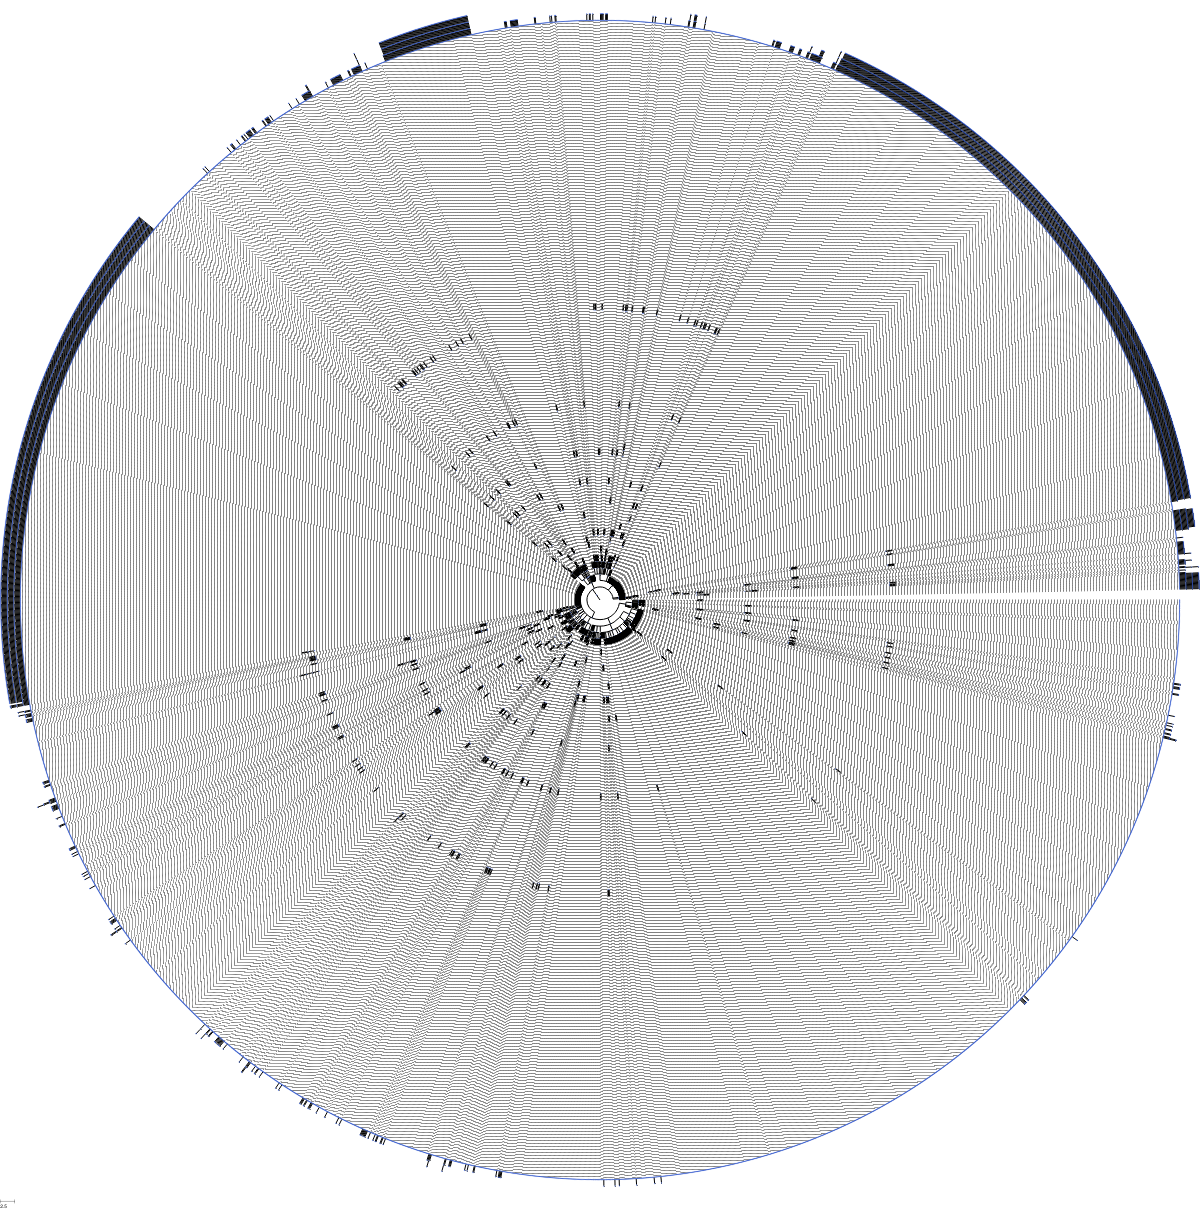

In [191]:
%store -r tree

# This is the part where we have to play with ETE's options to make this cool. Ideas:
# - It should be possible to render the tree only up to a specified level, e.g.
#   'phylum' or 'class'. There are two challenges: 1) we have a lot of 'incertae sedis'
#   that are grafted on anonymous parents, 2) the ETE API behaves inpredictably, I
#   try to prune children below a specified level but nothing seems to happen.
# - It should also be possible to render from another node than the root. I think 
#   that might just be matter of finding the right node and rendering from there,
#   e.g. showing all the Molluscs or whatever.
# - Visualizing the features (n tips, n barcodes) is possible through the 'faces',
#   example is here: https://www.biostars.org/p/153788/
# Nice to have but not essential:
# - Color coding would be nice for the clades. A way to do that is use HSV instead
#   of RGB, divide 360 by number of children's descendants (at root), then subdivide 
#   the segments further as you approach the tips.
# - It would be nice if we can collapse unbranched internal nodes, for monotypic
#   higher taxa.


circular_style = TreeStyle()
circular_style.mode = "c" # draw tree in circular mode
circular_style.scale = 20
circular_style.show_leaf_name = False
circular_style.draw_guiding_lines = False
tree.render(file_name='%%inline', w=1200, tree_style=circular_style)